<a href="https://colab.research.google.com/github/eshghinezhad/ML_Classifire_Student_Success/blob/master/Student_Success_Classifires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Assignment 2- Building Classifiers** ---------- **Monireh Eshghinezhad**
> #

In [8]:
import numpy as np
import pandas as pd

##  **Data Loading and Initial Cleaning** (Brief EDA)

In [9]:
student=pd.read_csv("MAI101 W26 A1 data v0.1.csv")

Base on the assignment1, the dataset contains 1,677 **rows** and 17 **columns**.
Several variables contain **missing** values.
The Business101Grade variable includes values **outside** the expected **range** (>100).
The status variable contains **invalid categories** ('S', 'X', 'V2'). Some column names contain spaces.

####Before proceeding with modeling, basic data cleaning was performed:

1.   Renamed columns to remove spaces.
2.   Kept only valid status values ('D', 'I').
3.   Removed records where Business101Grade exceeded 100.
4.   Reset the index after filtering.

## **Structural Fix:**

In [10]:
#assign the appropriate name for some features
student = student.rename(columns={
 "Math101 Grade": "Math101Grade",
 "Business101 Grade": "Business101Grade",
 "Overall Average Grade": "OverallAverageGrade"
})
# keeps only valid status.
valid_status = ['D', 'I']
student = student[student['status'].isin(valid_status)]
# keeps only valid Business101Grade
student = student[student['Business101Grade'] <= 100 ]

# creates a new index & Do not keep the old index as a separate column.
student = student.reset_index(drop=True)

## **Create the Target Variable**:
### Create the new column '**on_schedule**' (1 or 0) base on '**duration**' and '**totalSemesters**'

In [11]:
student['onSchedule'] = ((student.hasGraduated == 1) &
(student.totalSemesters <= (student.duration * 2 + 2))).astype(int)

## **Analyze Target Variable - Class Balance and Class Relationships:**

In [12]:
# Show the number and proportion of each class in target variable.
print(student.onSchedule.value_counts())
print("-"*50)
print (student["onSchedule"].value_counts(normalize=True))

onSchedule
0    1037
1     618
Name: count, dtype: int64
--------------------------------------------------
onSchedule
0    0.626586
1    0.373414
Name: proportion, dtype: float64


### The target variable shows a **moderate class imbalance**. Approximately 63% of students did not graduate on schedule, while 37% graduated on schedule.
> #### Because of this imbalance, evaluation metrics beyond overall accuracy, such as **precision**, **recall**, and  
**F1-score**, will be considered to properly **assess model performanc**e.

In [13]:
 # Show the relationship between the target variable and other features
display(student.groupby("onSchedule")["OverallAverageGrade"].mean())
display(pd.crosstab(student["status"], student["onSchedule"]))
display(pd.crosstab(student["gender"], student["onSchedule"]))
display(pd.crosstab(student["transfer_in"], student["onSchedule"]))
display(pd.crosstab(student["Mature"], student["onSchedule"]))

,OverallAverageGrade
onSchedule,
0,67.727896
1,79.663533


onSchedule,0,1
status,,
D,780,456
I,257,162


onSchedule,0,1
gender,,
F,366,249
M,671,369


onSchedule,0,1
transfer_in,,
0,734,329
1,303,289


onSchedule,0,1
Mature,,
0,541,235
1,496,383


## **`Feature` and `Target` separation**

In [14]:
numerical_features = ['duration', 'LangTestPercent','MathTestPercent',
                      'AptitudeTestPercent', 'transfer_in', 'Business101Grade',
                      'Mature']
categorical_features = ['program', 'status', 'gender', 'Math101Grade']

x = student[numerical_features + categorical_features]
y = student["onSchedule"]

## **Split dataset** into **Training(60%)**, **Validation(20%)** and **Test(20%)** sets
#####The data was split using a fixed random state for reproducibility and stratification to preserve the class distribution in both training and testing sets.

In [15]:
from sklearn.model_selection import train_test_split

# 1. Split into (Train + Val)(80%) and Test(20%)           random_state=10: generating same training and testing sets each time the code is run.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.2, random_state=10, stratify=y
)

# 2. Split (Train + Val) into separate Train(60%) and Validation(20%) sets      stratify=y: keeps the class distribution consistent.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=10, stratify=y_train_val
)

## Build the **ColumnTransformer** and **Pipeline**
Apply different transformations to different columns.
| Column Type   | Transformation       |
|---------------|----------------------|
| Numeric       |  **Median** + **Scaling**    |
| Categorical   |  **OneHotEncide**        |

In [16]:
from sklearn.compose import ColumnTransformer   # we have mixed columns(numeric + categorical). we need apply different transformations to different columns.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Define the pipelines for each type of feature
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Fills missing with median
    ('scaler', StandardScaler())                    # Scales the numericals for distance-based algorithms (KNN, SVM) is required.
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Handles new categories in test set
])

# 2. Combine them into one ColumnTransformer
full_prep = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

###  **Variable Issues & Steps Report**

| Variable Name    |	Issue Identified	       |  Step/Transformation Applied    |
|------------------|--------------------------|---------------------------------|
| onSchedule       | Not explicitly in dataset|Create the new column,using hasGraduated and totalSemesters columns.
| Numeric Features | Missing values, different scales|Imputed using median strategy, then standardized (Z-score scaling)|
|Categorical Features| Text values need numeric representation|One-Hot Encoding applied to convert categories to binary features|

####To prevent data leakage, all **imputation** and **scaling** parameters were derived exclusively from the training data (X_train and y_train) and then applied using a **ColumnTransformer** within the **pipelines**. Also applied stratification during the train, validation, and test split to maintain the class distribution ratio (63% / 37%) across all three sets.

# **Building KNN Model and Optimization**


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

knn_model = make_pipeline(full_prep, KNeighborsClassifier())   # builds a model structure.-> n_neighbors = 5 (default value)
knn_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration',
                                                   'LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'status',
                                                   'gender',
                                                   'Math101Grade'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [21]:
# Run the mode without optimizing
knn_model.fit(X_train, y_train)
knn_model.predict(X_test)
knn_model.score(X_test, y_test)

0.6465256797583081

In [23]:
from sklearn.metrics import accuracy_score

for k in [1, 5, 15, 50]:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train)

    y_train_pred = knn_model.predict(X_train)
    y_test_pred = knn_model.predict(X_test)

    print(f"k = {k}")
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
    print("-" * 40)

k = 1
Train Accuracy: 1.0
Test Accuracy : 0.6072507552870091
----------------------------------------
k = 5
Train Accuracy: 0.7633434038267876
Test Accuracy : 0.6465256797583081
----------------------------------------
k = 15
Train Accuracy: 0.7069486404833837
Test Accuracy : 0.6646525679758308
----------------------------------------
k = 50
Train Accuracy: 0.6998992950654582
Test Accuracy : 0.6676737160120846
----------------------------------------


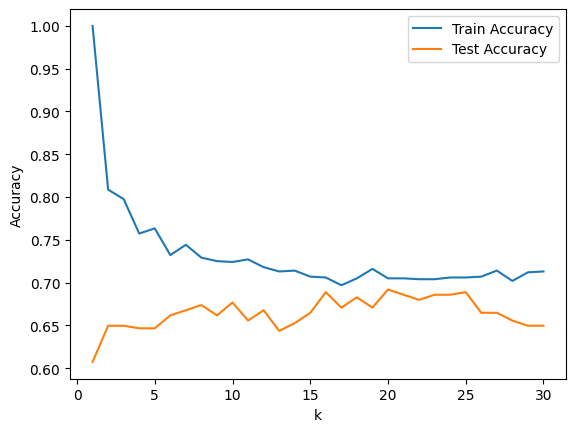

In [25]:
import matplotlib.pyplot as plt
train_scores = []
test_scores = []
k_values = range(1, 31)
for k in k_values:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train)

    train_scores.append(knn_model.score(X_train, y_train))
    test_scores.append(knn_model.score(X_test, y_test))

plt.plot(k_values, train_scores, label="Train Accuracy")
plt.plot(k_values, test_scores, label="Test Accuracy")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## **Tune Hyperparameter** :  n_neighbors

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}
# Use GridSearchCV to find the best parameter 'k' using the training+validation data
